In [24]:
#Import library in python
from Preprocessing import preprocess
import glob
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
import csv
from keras.models import Sequential,Model
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv1D,Activation,BatchNormalization,GlobalMaxPooling1D,Concatenate,Flatten,Dropout,Embedding
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score
import plotly.graph_objects as go
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [25]:
# Import preprocess files
preprocessing = preprocess()

In [26]:
# Preprocess data to generate the data
def generateWordList(fileData): # Generate list of preprocessed words from file
    finalSet = preprocessing.checkEmail(fileData) # Check emails in the file and add them to wordlist
    fileData = preprocessing.removeEmail(fileData) # Remove emails 
    finalSet = finalSet + preprocessing.checkWebsite(fileData) # Check for website and decimal number and add them to wordlist
    fileData = preprocessing.removeWebsite(fileData) # Remove webiste and decimal numbers 
    fileData = preprocessing.contractionsExpand(fileData) # Expand the contracted word
    fileData = preprocessing.caseChange(fileData) # Change case of file to lower case
    fileData = preprocessing.removePunctuations(fileData) # Remove punctutation 
    wordList = preprocessing.wordSeperator(fileData) # Seperate words by space
    for word in wordList: # For each words in word list
        if word.isdecimal(): # If number is present expand it 
            finalSet += preprocessing.changeNumber(word) # Generate number form of the number and add it to final list 
        else: 
            finalSet.append(preprocessing.lemmatizeWord(word)) # If it is word apply lemmatization
    return finalSet # Return the fnal word list

In [54]:
fileData = open("Annotated-Data.txt",encoding="utf8").read() # Load annotation files
count = 0 # Count the file -- not used now
documents = [] # store the documents
y = [] # Load the answer vector
for i in fileData.split("\n"): # Split data from the annotation file
    splitData = i.split("\t") # Split annotation and article text
    if len(splitData)>1: # If annotation file len > 1 that is some value is presents
        y.append(int(splitData[0])) # Load final annotation 
        documents.append(" ".join(generateWordList(" ".join(splitData[1:])))) # Load preprocessed annotation
        count += 1

In [55]:
# """***Semeval Data***"""
# fileData = open("SemEval-2019.txt",encoding="utf8").read()
# count = 0 
# documents = []
# y = []
# for i in fileData.split("\n"):
#     splitData = i.split(" ")
#     if len(splitData)>1:
#         y.append(int(splitData[1]))
#         documents.append(" ".join(generateWordList(" ".join(splitData[2:]))))
#         count += 1

In [56]:
max_features = 5000
maxlen = 1000
batch_size = 32
embedding_dims = 500
filters = 250
kernel_size = [2,3,4,5,6]
hidden_dims = 250
epochs = 20
classes = 3

In [57]:
oldy = y.copy()
encoder = LabelEncoder() # Create a label encoder
encoder.fit(y) # Fit label encoder
encodedY = encoder.transform(y) # Transform label 
y = np_utils.to_categorical(encodedY) # Get categorial label here 1X3 as 3 labels given

In [58]:
x_train, x_test, y_train, y_test = train_test_split(documents,y, test_size=0.20) # Split train and test data 

In [59]:
tokenizer = Tokenizer(num_words=max_features) # Create tokenizer 
tokenizer.fit_on_texts(x_train) # Fit train data to tokenizer
x_train = tokenizer.texts_to_sequences(x_train) # train_x data with tokeinzer output
x_test = tokenizer.texts_to_sequences(x_test) # test_x data with tokeinzer output
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen) # Pad sequence so that length of document remains same -- remove extra data
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)  # Pad sequence so that length of document remains same -- remove extra data

In [60]:
inputLayer = Input(shape=(maxlen,)) # Create input layer
embedding = Embedding(max_features,embedding_dims,input_length=maxlen)(inputLayer) # Create embedding layer to provide embedding to text
dropoutLayer = Dropout(0.2)(embedding) # Add dropout layer

convolution1 = Conv1D(filters,kernel_size[0],padding='valid',activation='relu',strides=1)(dropoutLayer) # Add convolution layer 1
branchNormaltize1 = BatchNormalization(momentum=0.5)(convolution1) # Batch normalize to provide better accuracy and fast processing
activation1 = Activation('relu')(branchNormaltize1) # Add relu activation layer to convolution 1
maxPooling1 = GlobalMaxPooling1D()(activation1) # Apply max polling to layer 1

convolution2 = Conv1D(filters,kernel_size[1],padding='valid',activation='relu',strides=1)(dropoutLayer) # Add convolution layer 2
branchNormaltize2 = BatchNormalization(momentum=0.5)(convolution2) # Batch normalize to provide better accuracy and fast processing
activation2 = Activation('relu')(branchNormaltize2) # Add relu activation layer to convolution 2
maxPooling2 = GlobalMaxPooling1D()(activation2) # Apply max polling to layer 2

convolution3 = Conv1D(filters,kernel_size[2],padding='valid',activation='relu',strides=1)(dropoutLayer) # Add convolution layer 3
branchNormaltize3 = BatchNormalization(momentum=0.5)(convolution3) # Batch normalize to provide better accuracy and fast processing
activation3 = Activation('relu')(branchNormaltize3) # Add relu activation layer to convolution 3
maxPooling3 = GlobalMaxPooling1D()(activation3) # Apply max polling to layer 3

convolution4 = Conv1D(filters,kernel_size[3],padding='valid',activation='relu',strides=1)(dropoutLayer) # Add convolution layer 4
branchNormaltize4 = BatchNormalization(momentum=0.5)(convolution4) # Batch normalize to provide better accuracy and fast processing
activation4 = Activation('relu')(branchNormaltize4) # Add relu activation layer to convolution 4
maxPooling4 = GlobalMaxPooling1D()(activation4) # Apply max polling to layer 4

convolution5 = Conv1D(filters,kernel_size[4],padding='valid',activation='relu',strides=1)(dropoutLayer) # Add convolution layer 5
branchNormaltize5 = BatchNormalization(momentum=0.5)(convolution5) # Batch normalize to provide better accuracy and fast processing
activation5 = Activation('relu')(branchNormaltize5) # Add relu activation layer to convolution 5
maxPooling5 = GlobalMaxPooling1D()(activation5) # Apply max polling to layer 5

concatenationLayer = Concatenate()([maxPooling1, maxPooling2, maxPooling3,maxPooling4,maxPooling5]) # Concatenate layers

dense1 = Dense(hidden_dims)(concatenationLayer) # Apply dense layer 1
dropoutLayer2 = Dropout(0.2)(dense1) # Add dropout layer 
activationRelu = Activation('relu')(dropoutLayer2) # Add relu activation layer

dense2 = Dense(classes)(activationRelu) # Apply dense layer 1
activationSoftmax = Activation('softmax')(dense2) # Add softmax layer which will be the final output

checkpoint = ModelCheckpoint("Model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model = Model(inputs=inputLayer, outputs=activationSoftmax) # Add input and output layer to create the network
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Compute with adamic adar and categorial cross entropy

In [61]:
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),callbacks=[checkpoint]) # Fit for the current dataset
model.load_weights("Model.hdf5")
answer = model.predict(x_test) # Get prediction output

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 724 samples, validate on 181 samples
Epoch 1/20
724/724 [==============================] - ETA: 4:06 - loss: 2.5972 - accuracy: 0.53 - ETA: 3:30 - loss: 9.2547 - accuracy: 0.40 - ETA: 3:17 - loss: 13.0425 - accuracy: 0.375 - ETA: 3:01 - loss: 13.8670 - accuracy: 0.343 - ETA: 2:46 - loss: 12.5166 - accuracy: 0.331 - ETA: 2:33 - loss: 11.3907 - accuracy: 0.328 - ETA: 2:22 - loss: 10.3026 - accuracy: 0.352 - ETA: 2:11 - loss: 9.5992 - accuracy: 0.371 - ETA: 2:01 - loss: 9.1564 - accuracy: 0.37 - ETA: 1:51 - loss: 8.6361 - accuracy: 0.38 - ETA: 1:42 - loss: 8.2580 - accuracy: 0.39 - ETA: 1:35 - loss: 8.1008 - accuracy: 0.38 - ETA: 1:28 - loss: 7.7835 - accuracy: 0.38 - ETA: 1:19 - loss: 7.5554 - accuracy: 0.38 - ETA: 1:10 - loss: 7.2956 - accuracy: 0.38 - ETA: 1:01 - loss: 7.0706 - accuracy: 0.38 - ETA: 51s - loss: 6.8570 - accuracy: 0.3805 - ETA: 42s - loss: 6.5978 - accuracy: 0.381 - ETA: 33s - loss: 6.3528 - accuracy: 0.376 - ETA: 24s - loss: 6.1434 - accuracy: 0.375 - ETA: 14s

724/724 [==============================] - ETA: 3:01 - loss: 0.1239 - accuracy: 0.93 - ETA: 2:55 - loss: 0.0856 - accuracy: 0.96 - ETA: 2:46 - loss: 0.0691 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0700 - accuracy: 0.98 - ETA: 2:29 - loss: 0.0863 - accuracy: 0.98 - ETA: 2:21 - loss: 0.0862 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0970 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0965 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0936 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0924 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0884 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0868 - accuracy: 0.98 - ETA: 1:24 - loss: 0.0861 - accuracy: 0.98 - ETA: 1:15 - loss: 0.0913 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0985 - accuracy: 0.98 - ETA: 57s - loss: 0.0956 - accuracy: 0.9863 - ETA: 49s - loss: 0.0945 - accuracy: 0.987 - ETA: 40s - loss: 0.0942 - accuracy: 0.987 - ETA: 31s - loss: 0.0917 - accuracy: 0.988 - ETA: 22s - loss: 0.0920 - accuracy: 0.987 - ETA: 14s - loss: 0.0986 - accuracy: 0.986 - ETA: 5s - loss: 0.0961 - accurac

Epoch 00013: val_accuracy did not improve from 0.57459
Epoch 14/20
724/724 [==============================] - ETA: 3:19 - loss: 0.0157 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0131 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0186 - accuracy: 1.00 - ETA: 2:50 - loss: 0.0202 - accuracy: 1.00 - ETA: 2:42 - loss: 0.0185 - accuracy: 1.00 - ETA: 2:33 - loss: 0.0170 - accuracy: 1.00 - ETA: 2:25 - loss: 0.0307 - accuracy: 0.99 - ETA: 2:15 - loss: 0.0278 - accuracy: 0.99 - ETA: 2:06 - loss: 0.0260 - accuracy: 0.99 - ETA: 1:57 - loss: 0.0250 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0233 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0220 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0378 - accuracy: 0.99 - ETA: 1:21 - loss: 0.0367 - accuracy: 0.99 - ETA: 1:12 - loss: 0.0413 - accuracy: 0.99 - ETA: 1:03 - loss: 0.0413 - accuracy: 0.99 - ETA: 53s - loss: 0.0406 - accuracy: 0.9890 - ETA: 44s - loss: 0.0392 - accuracy: 0.989 - ETA: 34s - loss: 0.0376 - accuracy: 0.990 - ETA: 24s - loss: 0.0363 - accuracy: 0.990 - ETA: 15s 


Epoch 00020: val_accuracy did not improve from 0.59669


In [ ]:
# model.load_weights("Model.hdf5")
# testCase = tokenizer.texts_to_sequences((np.array(documents))[[0,1,2,3,4,5,6,7,8,9,10]])
# testCase = pad_sequences(testCase, padding='post', maxlen=maxlen)
# answer = model.predict(testCase) # Get prediction output
# print(encoder.inverse_transform(answer.argmax(axis=-1)))

In [36]:
print("Precision score micro: ",precision_score(answer.argmax(axis=-1),y_test.argmax(axis=-1),average="micro")) # Print micro precision for final class value
print("Precision score macro: ",precision_score(answer.argmax(axis=-1),y_test.argmax(axis=-1),average="macro")) # Print macro precision for final class value

ValueError: Found input variables with inconsistent numbers of samples: [11, 181]

In [ ]:
print("Recall score micro : ",recall_score(answer.argmax(axis=-1),y_test.argmax(axis=-1),average="micro")) # Print micro recall for final class value
print("Recall score macro : ",recall_score(answer.argmax(axis=-1),y_test.argmax(axis=-1),average="macro")) # Print macro recall for final class value

In [ ]:
print("F1 score micro : ",f1_score(answer.argmax(axis=-1),y_test.argmax(axis=-1),average="micro")) # Print micro f1_score for final class value
print("F1 score macro : ",f1_score(answer.argmax(axis=-1),y_test.argmax(axis=-1),average="macro")) # Print macro f1_score for final class value

In [ ]:
confusion_matrix(answer.argmax(axis=-1),y_test.argmax(axis=-1))

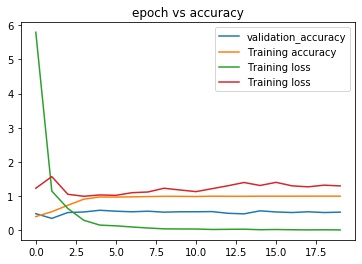

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(20)),y=history.history["val_accuracy"],mode="markers+lines"))

# plt.plot(list(range(20)),history.history["val_accuracy"],label="validation_accuracy")
# plt.plot(list(range(20)),history.history["accuracy"],label="Training accuracy")
# plt.plot(list(range(20)),history.history["loss"],label="Training loss")
# plt.plot(list(range(20)),history.history["val_loss"],label="Training loss")
# plt.legend()
# plt.title("epoch vs accuracy")
# plt.show()

In [ ]:
# Code to print 10 fold cross validation 
kfold = StratifiedKFold(n_splits=10, shuffle=True)
finalAccuracy = []
finalPrecisionMacro = []
finalPrecisionMicro = []
finalRecallMacro = []
finalRecallMicro = []
finalF1ScoreMacro = []
finalF1ScoreMicro = []
count = 0
for train,test in kfold.split(documents,oldy):
    encodedY = encoder.transform(oldy) # Transform label 
    y = np_utils.to_categorical(encodedY) # Get categorial label here 1X3 as 3 labels given
    tokenizer = Tokenizer(num_words=max_features) # Create tokenizer 
    tokenizer.fit_on_texts(np.array(documents)[train]) # Fit train data to tokenizer
    x_train = tokenizer.texts_to_sequences(np.array(documents)[train]) # train_x data with tokeinzer output
    x_test = tokenizer.texts_to_sequences(np.array(documents)[test]) # test_x data with tokeinzer output
    x_train = pad_sequences(x_train, padding='post', maxlen=maxlen) # Pad sequence so that length of document remains same -- remove extra data
    x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)  # Pad sequence so that length of document remains same -- remove extra data
    checkpoint = ModelCheckpoint("Model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    model = Model(inputs=inputLayer, outputs=activationSoftmax) # Add input and output layer to create the network
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Compute with adamic adar and categorial cross entropy
    model.fit(x_train, y[train],batch_size=batch_size,epochs=10,validation_data=(x_test, y[test]),callbacks=[checkpoint]) # Fit for the current dataset
    model.load_weights("Model.hdf5")
    answer = model.predict(x_test) 

    count+=1
    finalAccuracy += [accuracy_score(answer.argmax(axis=-1),y[test].argmax(axis=-1))]
    finalPrecisionMacro += [precision_score(answer.argmax(axis=-1),y[test].argmax(axis=-1),average="macro")]
    finalPrecisionMicro += [precision_score(answer.argmax(axis=-1),y[test].argmax(axis=-1),average="micro")]
    finalRecallMicro += [recall_score(answer.argmax(axis=-1),y[test].argmax(axis=-1),average="micro")]
    finalRecallMacro += [recall_score(answer.argmax(axis=-1),y[test].argmax(axis=-1),average="macro")]
    finalF1ScoreMicro += [f1_score(answer.argmax(axis=-1),y[test].argmax(axis=-1),average="micro")]
    finalF1ScoreMacro += [f1_score(answer.argmax(axis=-1),y[test].argmax(axis=-1),average="macro")]

    print(sum(finalAccuracy)/count,sum(finalPrecisionMacro)/count,sum(finalPrecisionMicro)/count,sum(finalRecallMicro)/count,sum(finalRecallMacro)/count,sum(finalF1ScoreMicro)/count,sum(finalF1ScoreMacro)/count)